In [1]:
import os
import numpy as np
import pandas as pd
import ml_tune_helpers.ts_plotter as ts_plt
from ml_tune_helpers.arima.stat_tests import StatTestWrapper
from ml_tune_helpers.arima.transformations import TransformHelper
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.api import SimpleExpSmoothing
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

##### Индексы рассчитаны по одной станции с максимальным количеством измеряемых загрязнителей.
##### Учет NO2 в выбранной стране (Нидерланды) не ведется с 2018 года. SO2 на выбранной станции не измеряется

In [2]:
CSV_AQI_PATH = '../datasources/aqi_calc/'
POL_CODES = [7, 6001, 5, 10]
POL_NAMES = {7: "O3", 6001: "PM2.5", 5: "PM10", 10: "CO"}

##### Загрузка рассчитанных индексов по загрязнителям

In [ ]:
from functools import reduce
df_list = []
for i in POL_CODES:
    directory = os.path.join(CSV_AQI_PATH,  str(i))
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        df_list.append(pd.read_csv(file_path, parse_dates=True, index_col='DatetimeEnd'))
df = reduce(lambda df1,df2: pd.merge(df1,df2,on='DatetimeEnd'), df_list)
df.columns = POL_NAMES.values()

##### Графики временных серий индекса качества воздуха

<AxesSubplot: title={'center': 'AQI по загрязнителям'}, xlabel='DatetimeEnd'>

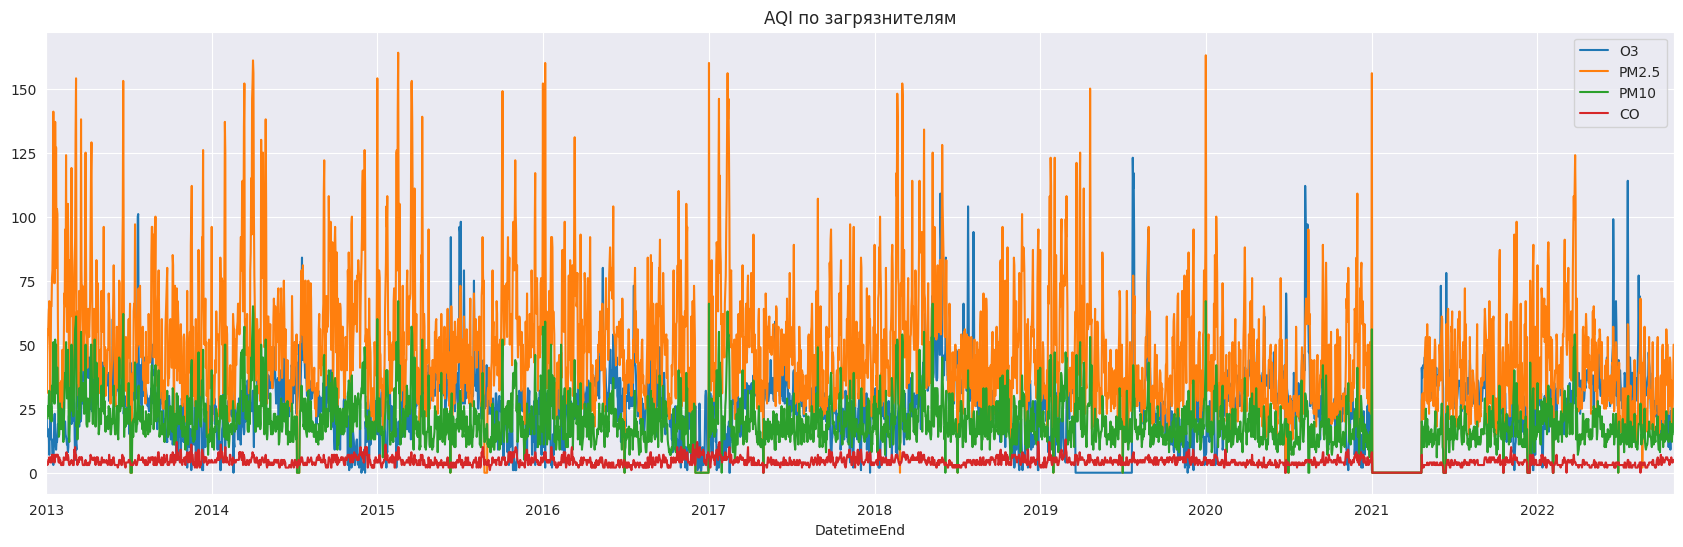

In [161]:
fig = plt.figure(figsize=(21, 6))
ax = fig.add_subplot(111)
df.plot(ax=ax, title="AQI по загрязнителям")

Вывод: преобладает загрязнитель PM2.5. В летний период есть промежуток времени, когда озон начинает оказывать наибольшее влияние на качество воздуха.

Единый индекс на день - это максимальный среди загрязнителей индекс, его необходимо рассчитать, остальные индексы можно удалить.
Из графика видно, что в первом квартале 2021 года станция не работала и никаких данных нет.
В последствии данная ситуация будет обработана. Но пока, для упрощения построения учебной модели, данные будут обрезаны 21-м годом

In [4]:
df['AQI'] = df.max(axis=1)
df.drop(columns=POL_NAMES.values(), inplace=True)
df = df[:'2020-12-31']

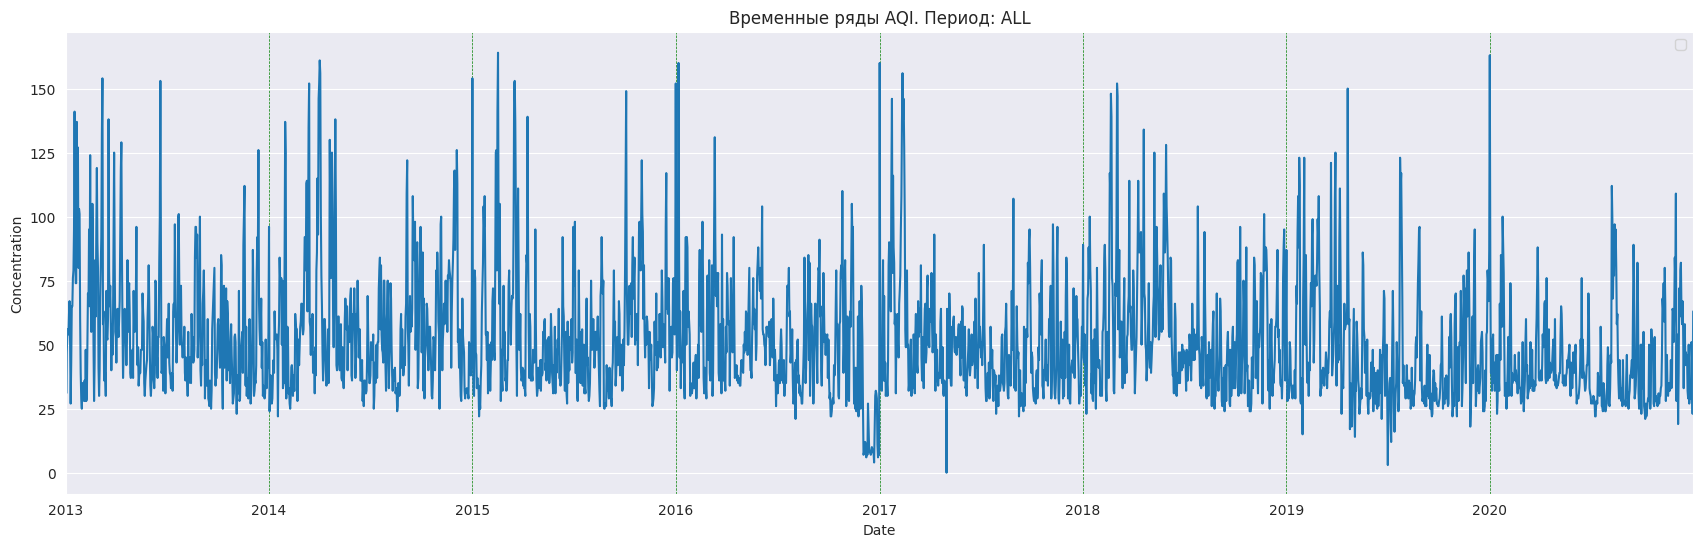

In [164]:
period_name = 'ALL'
ts_plt.plot_ts(df, title=f'Временные ряды AQI. Период: {period_name}', value_column='AQI')

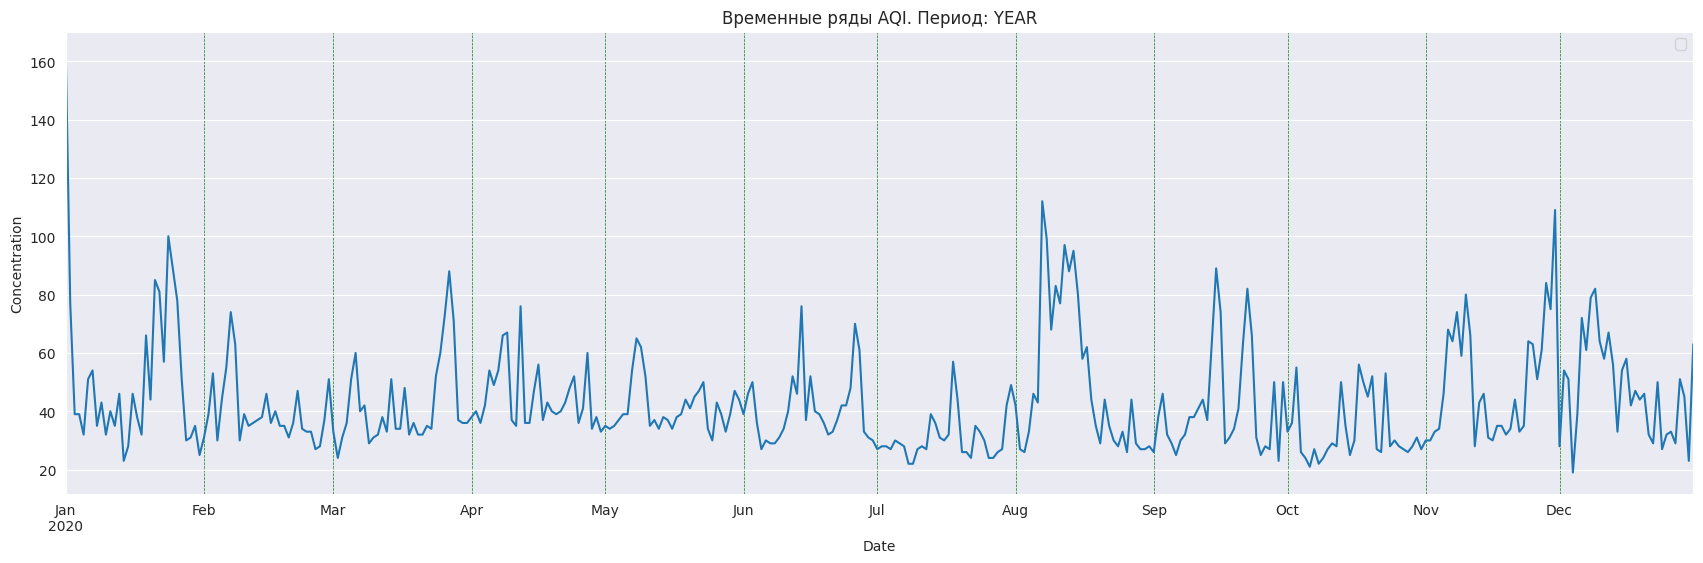

In [165]:
period_name = 'YEAR'
ts_plt.plot_ts(df, date_from='2020-01-01', date_to='2021-01-01', title=f'Временные ряды AQI. Период: {period_name}', value_column='AQI')

Из графиков видно, что возможно есть годовая сезонность. Недельной похоже нет. Также не виден тренд.

##### Анализ стационарности временного ряда. Дифференцирование по возможным сезонностям

Проверки на стационарность / Автокорреляцию / Частичную автокорреляцию - без дифференцирования
The ADF test statistic -19.907046    pvalue: 0.00   maximal Lag: 2   critical values: {'1%': -3.4325922267632847, '5%': -2.8625306663912187, '10%': -2.567297359477856}
ADF: stationary
The KPSS test statistic 1.886933    pvalue: 0.01   maximal Lag: 24   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: stationary


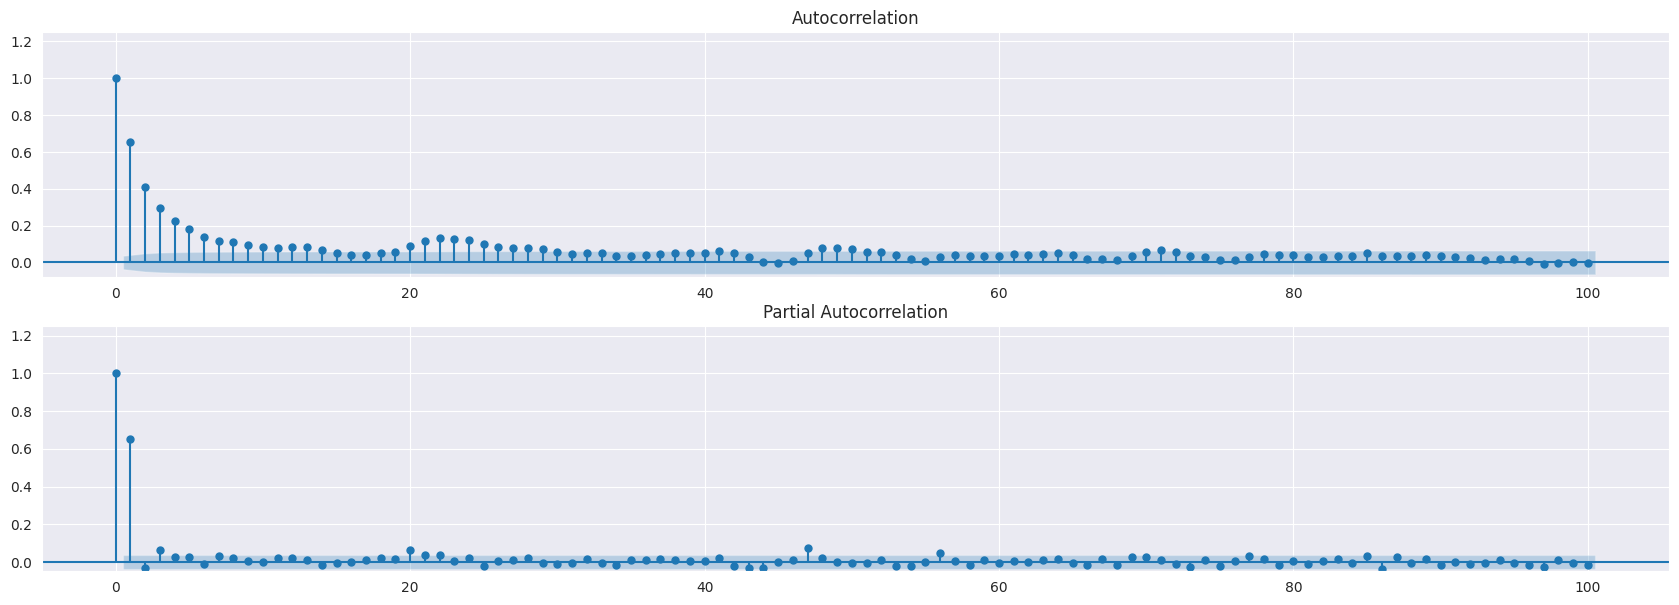

,AQI
DatetimeEnd,
2013-01-01 00:00:00+01:00,64
2013-01-02 00:00:00+01:00,31
2013-01-03 00:00:00+01:00,47
2013-01-04 00:00:00+01:00,54
2013-01-05 00:00:00+01:00,56
...,...
2020-12-27 00:00:00+01:00,29
2020-12-28 00:00:00+01:00,51
2020-12-29 00:00:00+01:00,45


In [166]:
print(f'Проверки на стационарность / Автокорреляцию / Частичную автокорреляцию - без дифференцирования')
StatTestWrapper.pre_analise(df, column_name='AQI', lags=100)

В соответствии с тестами Дики-Фуллера и KPSS ряд является стационарным, следовательно, к нему можно применить модель ARMA.
Сезонность в тесте не видна, но это может быть следствием того, что автокорреляция и частичная автокорреляция построены для лага равного 100, а годовая сезонность составляет 365 лагов. Значимыми значениями p могут быть 1,3, 20. Значимыми значениями q могут быть 1-6, 20-24.

Проверки на стационарность / Автокорреляцию / Частичную автокорреляцию - с дифференцированием по году
The ADF test statistic -19.157052    pvalue: 0.00   maximal Lag: 2   critical values: {'1%': -3.43291399811863, '5%': -2.8626727710866504, '10%': -2.5673730161669357}
ADF: stationary
The KPSS test statistic 0.133354    pvalue: 0.10   maximal Lag: 22   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: non-stationary


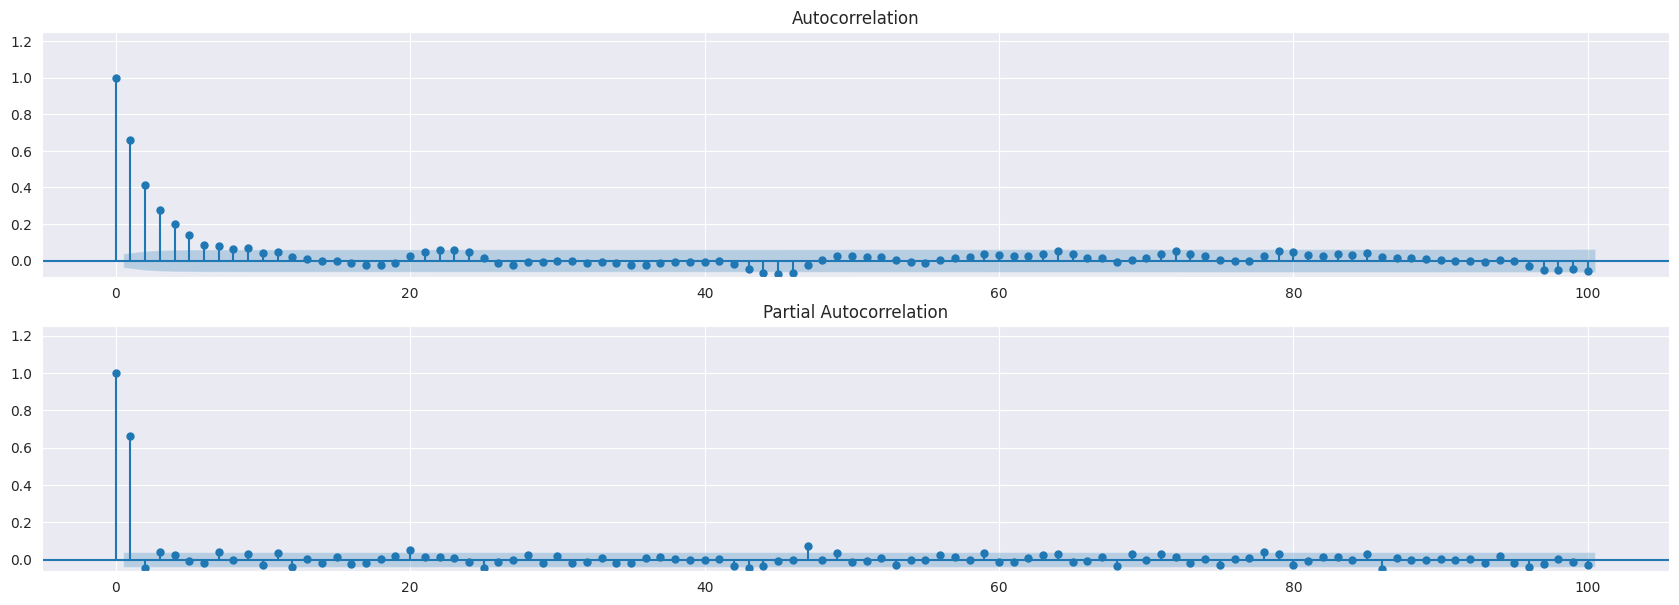

,AQI
DatetimeEnd,
2014-01-01 00:00:00+01:00,32.0
2014-01-02 00:00:00+01:00,-7.0
2014-01-03 00:00:00+01:00,-11.0
2014-01-04 00:00:00+01:00,-16.0
2014-01-05 00:00:00+01:00,-22.0
...,...
2020-12-27 00:00:00+01:00,-26.0
2020-12-28 00:00:00+01:00,-28.0
2020-12-29 00:00:00+01:00,-30.0


In [167]:
print(f'Проверки на стационарность / Автокорреляцию / Частичную автокорреляцию - с дифференцированием по году')
StatTestWrapper.pre_analise(df, column_name='AQI', diffs_needed=[('Y', 1)], lags=100)

В соответствии с тестом KPSS после дифференцирования по году ряд перестал быть стационарным, хотя казалось, что годовая сезонность есть. Но при этом компонента MA затухает быстрее, чем без дифференцирования. Стоит попробовать продифференцировать ряд по году.

Проверки на стационарность / Автокорреляцию / Частичную автокорреляцию - с дифференцированием по году и неделе
The ADF test statistic -14.841095    pvalue: 0.00   maximal Lag: 27   critical values: {'1%': -3.4329476085791493, '5%': -2.8626876136761292, '10%': -2.5673809185248175}
ADF: stationary
The KPSS test statistic 0.005600    pvalue: 0.10   maximal Lag: 15   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: non-stationary


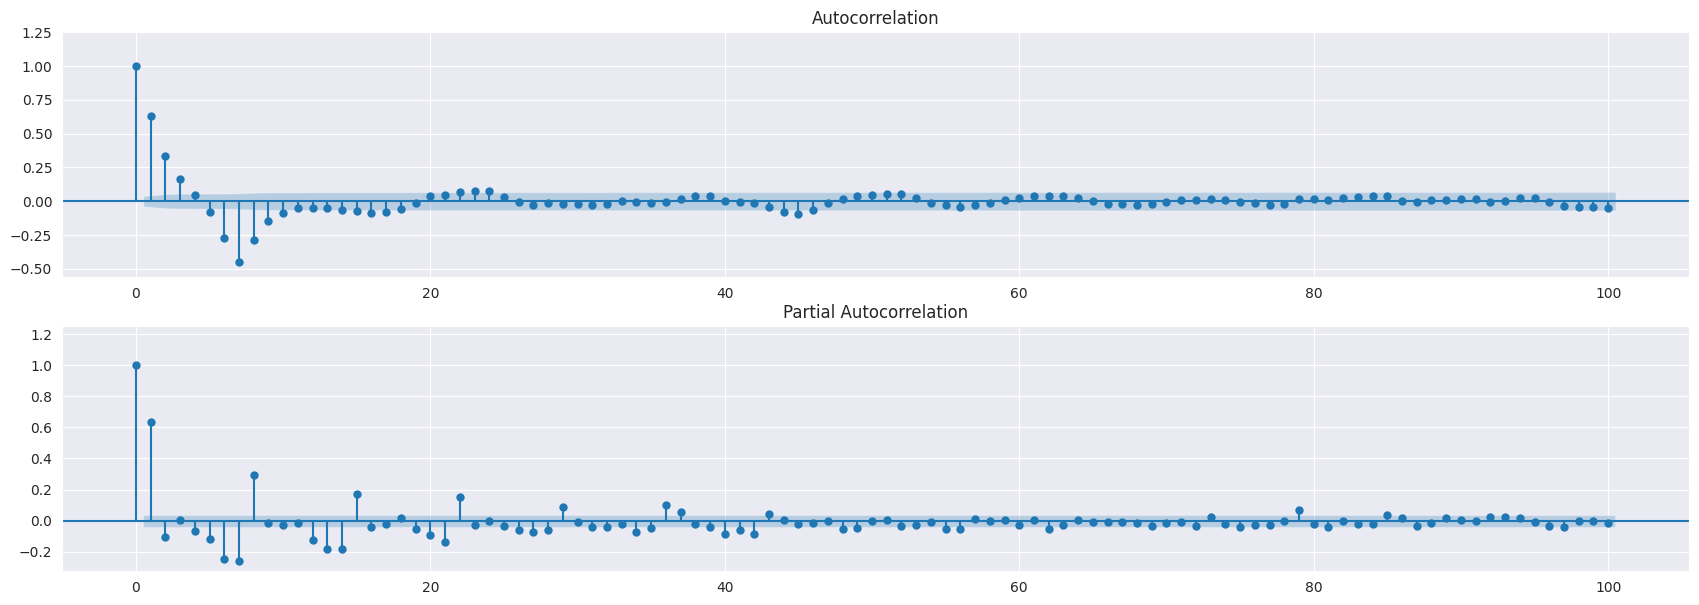

,AQI
DatetimeEnd,
2014-01-08 00:00:00+01:00,-61.0
2014-01-09 00:00:00+01:00,1.0
2014-01-10 00:00:00+01:00,23.0
2014-01-11 00:00:00+01:00,36.0
2014-01-12 00:00:00+01:00,11.0
...,...
2020-12-27 00:00:00+01:00,-48.0
2020-12-28 00:00:00+01:00,-35.0
2020-12-29 00:00:00+01:00,-35.0


In [168]:
print(f'Проверки на стационарность / Автокорреляцию / Частичную автокорреляцию - с дифференцированием по году и неделе')
StatTestWrapper.pre_analise(df, column_name='AQI', diffs_needed=[('Y', 1), ('W', 1)], lags=100)

Проверки на стационарность / Автокорреляцию / Частичную автокорреляцию - с дифференцированием по неделе
The ADF test statistic -13.763815    pvalue: 0.00   maximal Lag: 28   critical values: {'1%': -3.4326178883893763, '5%': -2.862541999961805, '10%': -2.567303393388591}
ADF: stationary
The KPSS test statistic 0.003572    pvalue: 0.10   maximal Lag: 16   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: non-stationary


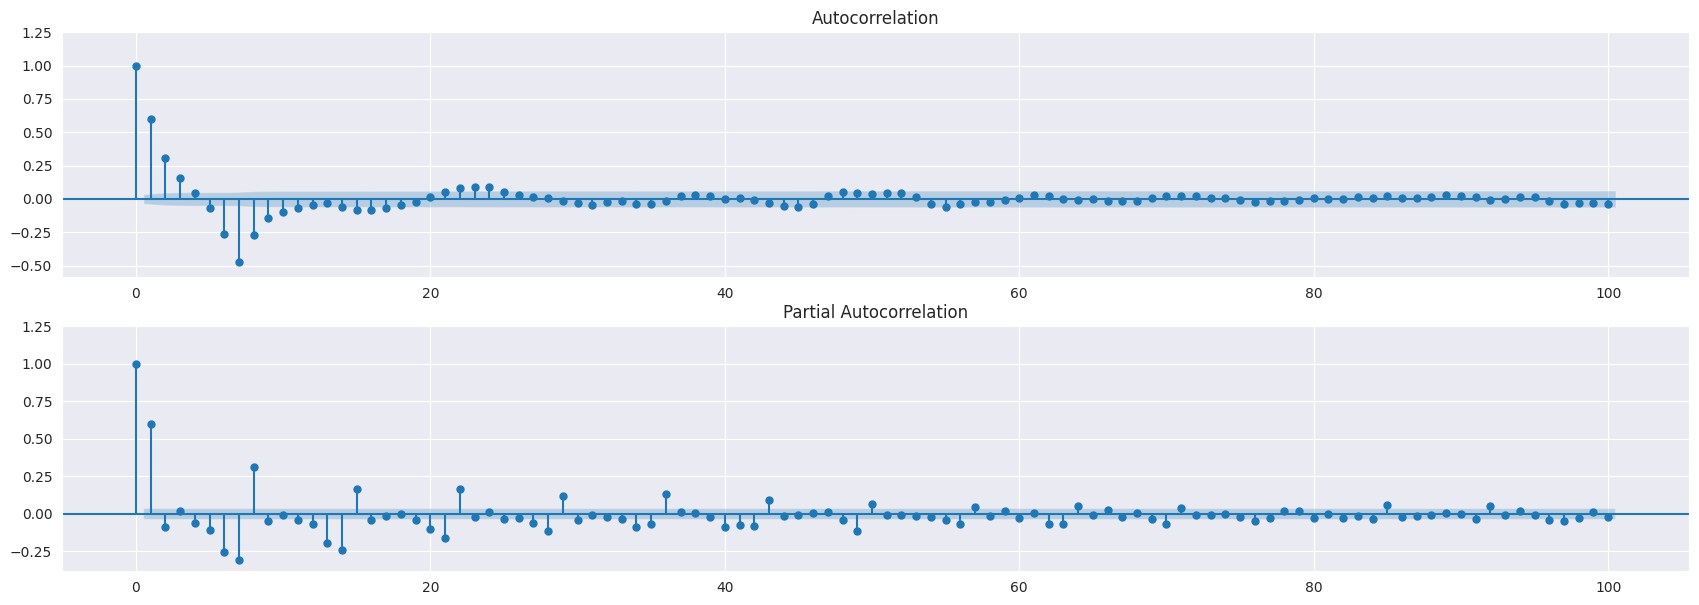

,AQI
DatetimeEnd,
2013-01-08 00:00:00+01:00,3.0
2013-01-09 00:00:00+01:00,19.0
2013-01-10 00:00:00+01:00,-20.0
2013-01-11 00:00:00+01:00,-11.0
2013-01-12 00:00:00+01:00,9.0
...,...
2020-12-27 00:00:00+01:00,-17.0
2020-12-28 00:00:00+01:00,19.0
2020-12-29 00:00:00+01:00,16.0


In [169]:
print(f'Проверки на стационарность / Автокорреляцию / Частичную автокорреляцию - с дифференцированием по неделе')
StatTestWrapper.pre_analise(df, column_name='AQI', diffs_needed=[('W', 1)], lags=100)

И KPSS тест, и графики автокорреляций показывают, что дифференцирование по неделе ухудшает стационарность ряда.

##### Разложение временного ряда на компоненты

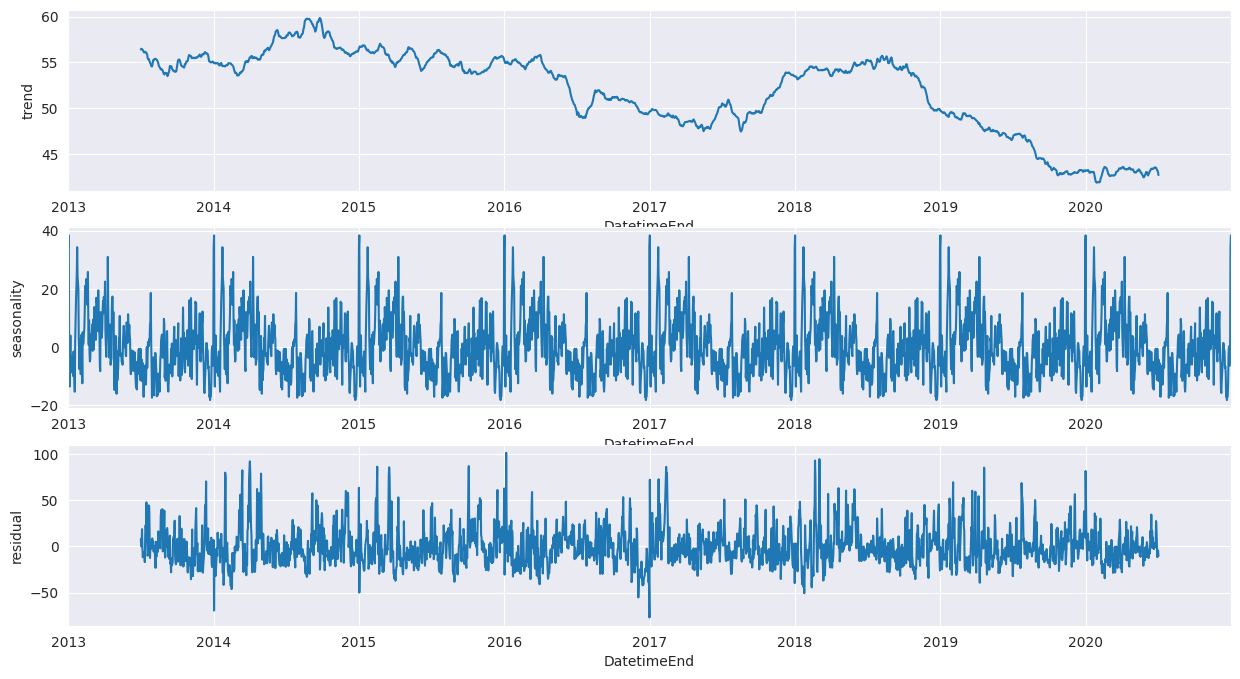

In [141]:
res = seasonal_decompose(df, model = "additive",period = 365)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.seasonal.plot(ax=ax2,ylabel = "seasonality")
res.resid.plot(ax=ax3,ylabel = "residual")
plt.show()

Были выделены нисходящий тренд и сезонность. Но при этом ряд остатков сравним, а иногда и превышает, сезонный ряд и тренд. Это наводит на мысль о том, что подобное разделение некорректно

##### Подбор параметров для SARIMAX модели

In [175]:
print('Подбор дифференцирования по тренду с помощью модуля pmdarima:')
print(f'Adf test, d: {ndiffs(df, test="adf")}')
print(f'KPSS test, d: {ndiffs(df, test="kpss")}')

Подбор дифференцирования по тренду с помощью модуля pmdarima:
Adf Test, d: 0
KPSS test, d: 1


In [176]:
print('Подбор дифференцирования по сезону с помощью модуля pmdarima:')
print(f'Canova-Hansen test, m=365, D: {nsdiffs(df, m=365, max_D=7, test="ch")}')
print(f'OCSB test, m=365, D: {nsdiffs(df, m=365, max_D=7, test="ocsb")}')
print(f'Canova-Hansen test, m=7, D: {nsdiffs(df, m=7, max_D=7, test="ch")}')
print(f'OCSB test, m=7, D: {nsdiffs(df, m=7, max_D=7, test="ocsb")}')

Подбор дифференцирования по сезону с помощью модуля pmdarima:
Canova-Hansen test, m=365, D: 6
OCSB test, m=365, D: 0
Canova-Hansen test, m=7, D: 0
OCSB test, m=7, D: 0


Автоподбор параметров модели с помощью модуля pmarima. К сожалению, подбор с сезонностью в 365 дней выполняется слишком медленно. Придется вводить сезонность как экзогенный компонент

In [13]:
model = pm.auto_arima(df, start_p=0, start_q=0,
                             max_p=7, max_q=24,
                             seasonal=False,
                             d=1, trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25679.162, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25619.244, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25566.335, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25677.170, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=25312.131, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.71 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=25202.592, Time=1.00 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.40 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=25154.459, Time=1.92 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=5.08 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=25143.332, Time=2.49 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=6.86 sec
 ARIMA(0,1,6)(0,0,0)[0] intercept   : AIC=25124.080, Time=4.04 sec
 ARIMA(1,1,6)(0,0,0)[0] intercept   : AIC=inf, Ti

Фурье-трансформация для учета сезонности по году (для 2х (k=1) и 4х (k=2) серий)

In [5]:
exog_k1 = TransformHelper.apply_fourier(df)
exog_k2 = TransformHelper.apply_fourier(df, k_sins=2)

In [11]:
def split_ts(ts: pd.DataFrame, pred_interval: int):
    ts_train = ts.iloc[:(len(ts)- pred_interval)]
    ts_test = ts.iloc[(len(ts)- pred_interval):]
    return ts_train, ts_test

In [12]:
_pred_interval=365
df_train, df_test = split_ts(df, _pred_interval)
exog_k1_train, exog_k1_test = split_ts(exog_k1, _pred_interval)
exog_k2_train, exog_k2_test = split_ts(exog_k2, _pred_interval)

In [40]:
model_no_exog = sm.tsa.statespace.SARIMAX(df_train, order=(0, 1, 6)).fit(disp=0)
model_no_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    AQI   No. Observations:                 2557
Model:               SARIMAX(0, 1, 6)   Log Likelihood              -11041.499
Date:                Sat, 24 Dec 2022   AIC                          22096.998
Time:                        04:24:58   BIC                          22137.921
Sample:                    01-01-2013   HQIC                         22111.838
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3202      0.013    -23.758      0.000      -0.347      -0.294
ma.L2         -0.3004      0.019    -16.109      0.000      -0.337      -0.264
ma.L3         -0.1416      0.021     -6.645      0.000      -0.183      -0.100
ma.L4         -0.0750      0.019     -4.044      0.000      -0.111      -0.039
ma.L5         -0.0357      0.018     -1.981      0.048      -0.071      -0.000
ma.L6         -0.0882      0.019     -4.726      0.000      -0.125      -0.052
sigma2       330.6019      5.547     59.603      0.000     319.731     341.473
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1831.40
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
model_exog_k1 = sm.tsa.statespace.SARIMAX(df_train, order=(0, 1, 6), exog=exog_k1_train).fit(disp=0)
model_exog_k1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    AQI   No. Observations:                 2557
Model:               SARIMAX(0, 1, 6)   Log Likelihood              -11029.972
Date:                Sat, 24 Dec 2022   AIC                          22077.945
Time:                        04:25:09   BIC                          22130.561
Sample:                    01-01-2013   HQIC                         22097.026
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
FOURIER_S365-0     5.2238      1.325      3.942      0.000       2.626       7.821
FOURIER_C365-0     3.9591      1.329      2.978      0.003       1.353       6.565
ma.L1             -0.3301      0.014    -23.474      0.000      -0.358      -0.303
ma.L2             -0.3074      0.019    -16.554      0.000      -0.344      -0.271
ma.L3             -0.1458      0.021     -6.821      0.000      -0.188      -0.104
ma.L4             -0.0783      0.019     -4.225      0.000      -0.115      -0.042
ma.L5             -0.0391      0.018     -2.123      0.034      -0.075      -0.003
ma.L6             -0.0920      0.018     -5.028      0.000      -0.128      -0.056
sigma2           327.4343      6.047     54.149      0.000     315.583     339.286
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1612.50
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
model_exog_k2 = sm.tsa.statespace.SARIMAX(df_train, order=(0, 1, 6), exog=exog_k2_train).fit(disp=0)
model_exog_k2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    AQI   No. Observations:                 2557
Model:               SARIMAX(0, 1, 6)   Log Likelihood              -11026.454
Date:                Sat, 24 Dec 2022   AIC                          22074.908
Time:                        04:25:32   BIC                          22139.216
Sample:                    01-01-2013   HQIC                         22098.228
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
FOURIER_S365-0     5.1968      1.328      3.913      0.000       2.594       7.800
FOURIER_C365-0     3.9716      1.375      2.888      0.004       1.276       6.667
FOURIER_S365-1     1.3508      1.342      1.006      0.314      -1.280       3.982
FOURIER_C365-1    -3.0436      1.264     -2.409      0.016      -5.520      -0.567
ma.L1             -0.3322      0.014    -23.549      0.000      -0.360      -0.305
ma.L2             -0.3092      0.019    -16.548      0.000      -0.346      -0.273
ma.L3             -0.1467      0.021     -6.837      0.000      -0.189      -0.105
ma.L4             -0.0770      0.019     -4.141      0.000      -0.113      -0.041
ma.L5             -0.0374      0.018     -2.039      0.041      -0.073      -0.001
ma.L6             -0.0899      0.018     -4.877      0.000      -0.126      -0.054
sigma2           326.6245      6.006     54.383      0.000     314.853     338.396
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1648.86
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Были протестированы 3 модели с рекомендованными автоподбором p, d, q = 0, 1, 6, с экзогенными данными Фурье-трансформации первого и второго порядка. Наименьший AIC 22074 показала модель с Фурье-трансформацией второго порядка. pValue всех параметров (кроме FOURIER_S365-1) являются статистически значимыми.
Стоит также попробовать рассчитать модель для p и q по графикам автокорреляции

##### Анализ остатков модели

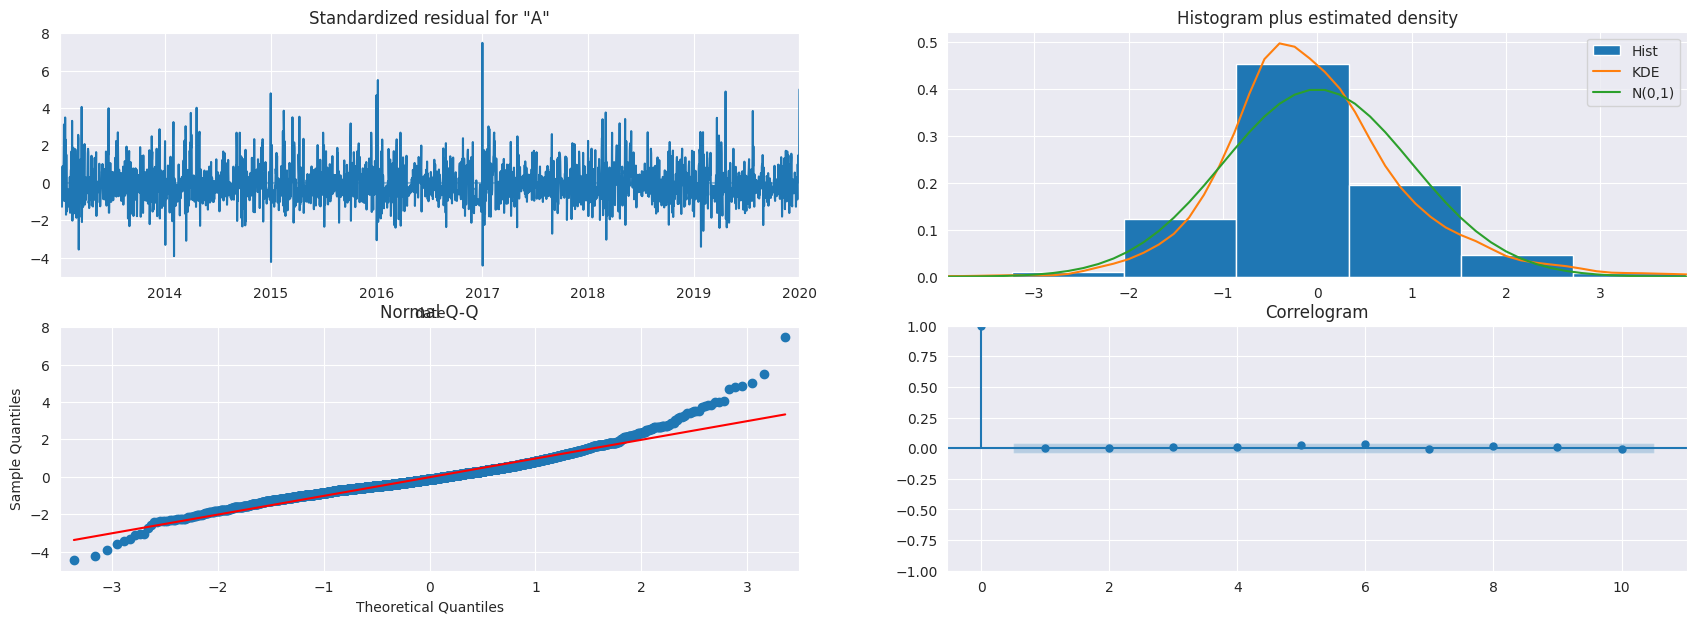

The KPSS test statistic 0.043249    pvalue: 0.10   maximal Lag: 7   table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS: non-stationary


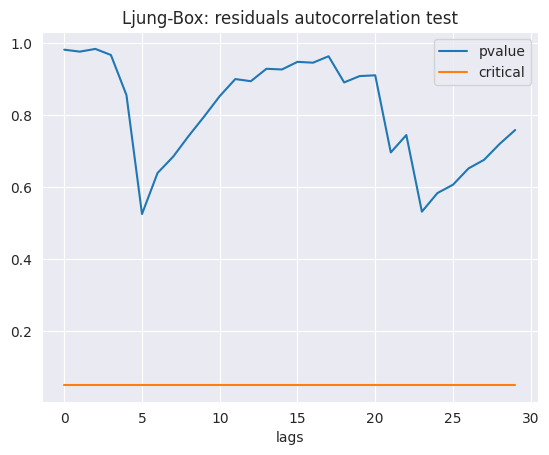

The Durbin-Watson residuals statistics 1.985214
Durbin-Watson: residuals are not correlated
The Wilcoxon residuals statistic 1461512.000000, pvalue: 0.00
Wilcoxon: residuals are biased


In [20]:
StatTestWrapper.get_residuals_analysis(model_exog_k2)

Вывод: Остатки некоррелирован, но их ряд нестационарен, распределение отклоняется от нормального, остатки смещены. Т.е. результат не слишком хорош. Но это не удивительно, учитывая сильный разброс данных.

##### Расчет ошибки прогноза на временном ряду с помощью кросс-валидации. Сравнение со средним по всему временному ряду

In [ ]:

tscv = TimeSeriesSplit(n_splits = 10)
rmse = []
mae = []
rmse_dfm = []
mae_dfm = []
all_predictions = None
aqi_mean = df['AQI'].mean()
for train_index, test_index in tscv.split(df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    cv_exog_train, cv_exog_test = exog_k2.iloc[train_index], exog_k2.iloc[test_index]
    cv_model = sm.tsa.statespace.SARIMAX(cv_train, order=(0, 1, 6), exog=cv_exog_train).fit(disp=0)
    predictions = cv_model.predict(start=cv_train.shape[0], end=cv_train.shape[0] + cv_test.shape[0] - 1, exog=cv_exog_test)
    if all_predictions is None:
        all_predictions = predictions
    else:
        all_predictions = pd.concat([all_predictions, predictions], axis=0)
    rmse.append(np.sqrt(mean_squared_error(cv_test.values, predictions)))
    mae.append(mean_absolute_error(cv_test.values, predictions))

    dfmean = pd.DataFrame(index=cv_test.index)
    dfmean['AQI'] = aqi_mean
    rmse_dfm.append(np.sqrt(mean_squared_error(cv_test.values, dfmean.values)))
    mae_dfm.append(mean_absolute_error(cv_test.values, dfmean.values))

rmse_df_mean = np.mean(rmse_dfm)
rmse_mean = np.mean(rmse)
mae_df_mean = np.mean(mae_dfm)
mae_mean = np.mean(mae)

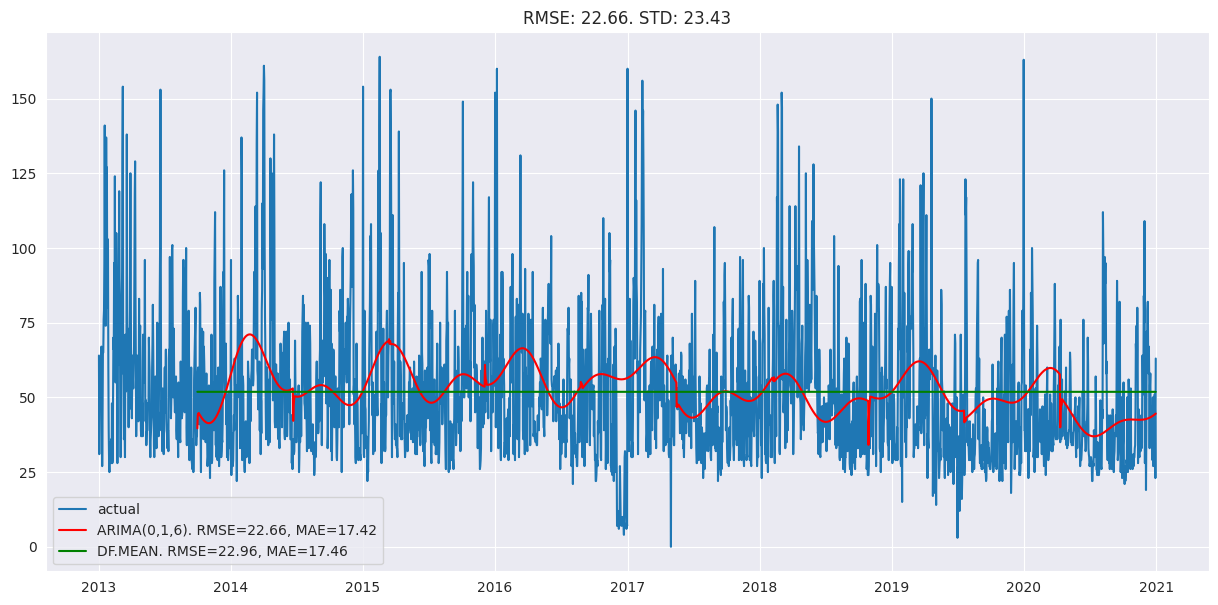

In [30]:
dfmean = pd.DataFrame(index=all_predictions.index)
dfmean['AQI'] = df['AQI'].mean()

plt.figure(figsize=(15, 7))
plt.title("RMSE: %.2f. STD: %.2f" % (rmse_mean, df['AQI'].std()))
plt.plot(df, label="actual")
plt.plot(all_predictions, color="r", label="ARIMA(0,1,6). RMSE=%.2f, MAE=%.2f" % (rmse_mean, mae_mean))
plt.plot(dfmean, color="g", label="DF.MEAN. RMSE=%.2f, MAE=%.2f" % (rmse_df_mean, mae_df_mean))
plt.legend()
plt.show()

Вывод: На графике видно, что Арима воспроизводить сезонность и нисходящий тренд. Но RMSE и MAE в итоге практически не отличаются от RMSE и MAE при прогнозировании просто средним значением AQI по всему временному ряду.

In [32]:
df_lag_1 = df.shift(1)[1:]
rmse_lag1 = np.sqrt(mean_squared_error(df.values[1:], df_lag_1.values))
print('LAG 1. RMSE=%.2f' % rmse_lag1)

LAG 1. RMSE=19.51


Даже прогнозирование данного ряда простым смещением на 1 день вперед в итоге является лучшим прогнозом с ошибкой RMSE=19.51

##### Краткосрочный прогноз и сравнение различных моделей

In [45]:
def get_compared_forecast(pred_interval_s: int, ts: pd.DataFrame, order: tuple, exog: pd.DataFrame = None):
    # пересчет модели
    df_train_s, df_test_s = split_ts(ts, pred_interval_s)
    exog_k2_train_s, exog_k2_test_s = split_ts(exog, pred_interval_s)
    model_exog_k2_s = sm.tsa.statespace.SARIMAX(df_train_s, order=order, exog=exog_k2_train_s).fit(disp=0)
    _predictions = model_exog_k2_s.predict(start=df_train_s.shape[0], end=df_train_s.shape[0] + pred_interval_s - 1, exog=exog_k2_test_s)
    rmse_arima_fin = np.sqrt(mean_squared_error(df_test_s.values, _predictions))

    # данные для простого среднего
    _dfmean = pd.DataFrame(index=df_test_s.index)
    _dfmean['AQI'] = ts['AQI'].mean()
    rmse_dfmean = np.sqrt(mean_squared_error(df_test_s.values, _dfmean))

    # простое экспоненциальное сглаживание с различными альфа
    ses = SimpleExpSmoothing(df_train_s)
    model_ses_a01 = ses.fit(smoothing_level = 0.1, optimized = False)
    prediction_ses_a01 = model_ses_a01.forecast(pred_interval_s)
    rmse_ses_a01 = np.sqrt(mean_squared_error(df_test_s.values, prediction_ses_a01))

    model_ses_a05 = ses.fit(smoothing_level = 0.5, optimized = False)
    prediction_ses_a05 = model_ses_a05.forecast(pred_interval_s)
    rmse_ses_a05 = np.sqrt(mean_squared_error(df_test_s.values, prediction_ses_a05))

    model_ses_a1 = ses.fit(smoothing_level = 1, optimized = False)
    prediction_ses_a1 = model_ses_a1.forecast(pred_interval_s)
    rmse_ses_a1 = np.sqrt(mean_squared_error(df_test_s.values, prediction_ses_a1))


    plt.figure(figsize=(15, 7))
    plt.title(f"Прогноз AQI на последние {pred_interval_s} дней")
    plt.plot(df_test_s, label="actual")
    plt.plot(_predictions, color="r", label="ARIMA(0,1,6). RMSE=%.2f" % rmse_arima_fin)
    plt.plot(_dfmean, color="g", label="DF.MEAN. RMSE=%.2f" % rmse_dfmean)
    plt.plot(prediction_ses_a01, color="yellow", label="SES a=0.1. RMSE=%.2f" % rmse_ses_a01)
    plt.plot(prediction_ses_a05, color="darkorange", label="SES a=0.5. RMSE=%.2f" % rmse_ses_a05)
    plt.plot(prediction_ses_a1, color="brown", label="SES a=1. RMSE=%.2f" % rmse_ses_a1)
    plt.plot()
    plt.legend()
    plt.grid(True)
    plt.show()

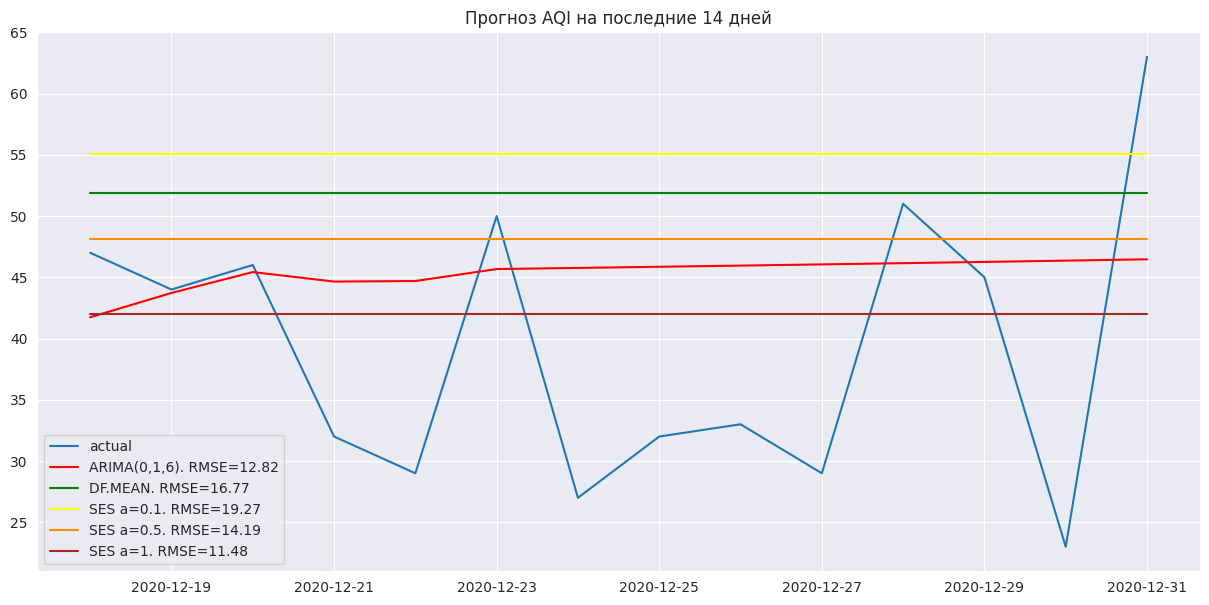

In [46]:
get_compared_forecast(pred_interval_s=14, ts=df, order = (0,1,6), exog=exog_k2)

Вывод: Арима неплохо справилась с прогнозом на последние 14 дней 2020 года. Хотя все равно хуже, чем простое экспоненциальное сглаживание с альфа=1 (что есть то же самое, что и смещение на 1 день).

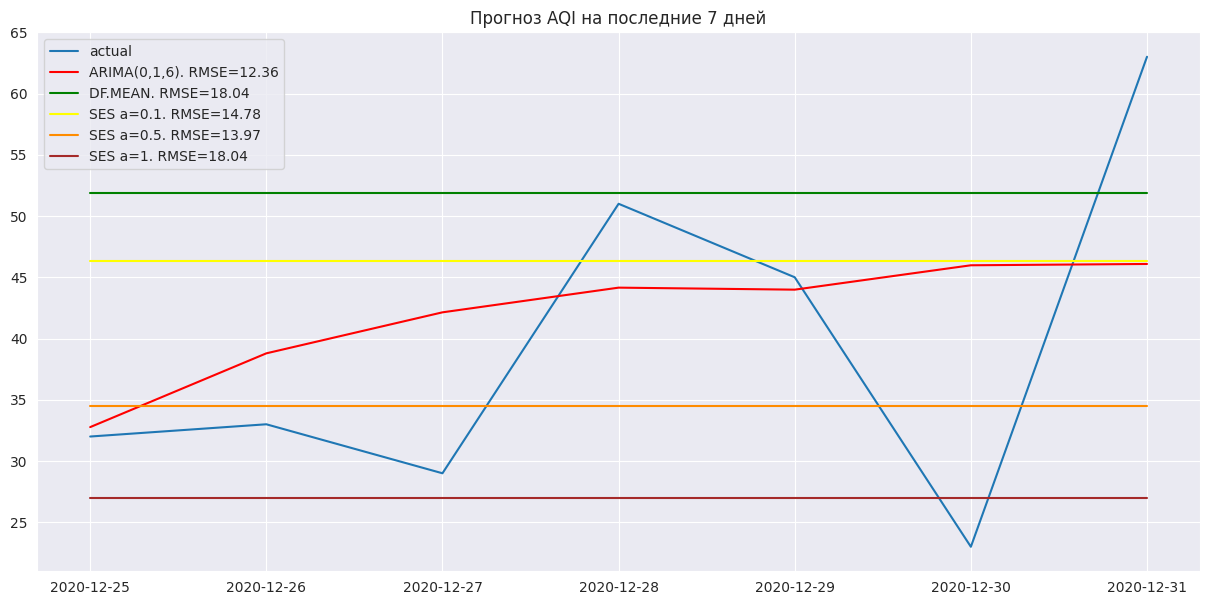

In [47]:
get_compared_forecast(pred_interval_s=7, ts=df, order = (0,1,6), exog=exog_k2)

Вывод: Арима лучше всех других моделей справилась с прогнозом на последние 7 дней 2020 года.